# Lecture 1: Homework - Students



## Objective

The goal of this assignment is to collect social network data from  Bluesky or Mastodon, construct a follower network, and perform comprehensive network analysis. You will apply the concepts learned in Lecture 1 including network metrics, centrality measures, and community structure analysis.

## Data Collection

Collect follower network data using **ONE** of the following platforms:
- **Bluesky**: Use the AT Protocol API to collect followers
- **Mastodon**: Use the Mastodon API to collect followers from your instance

**Data Requirements:**
- Start with 1 main account
- Collect first-degree followers (at least 100)
- Select 2 of those followers and collect their followers (second-degree, limit 50 each)
- Build a co-occurrence network based on shared followers

## Tasks

### Task 1: Data Collection
- Authenticate with your chosen platform (Bluesky or Mastodon)
- Collect first-degree followers (at least 100) from 1 main account
- Select 2 followers and collect their followers (second-degree, limit 50 each)
- Organize the data into a structured format

### Task 2: Build Network Structure
- Create a follower dictionary from the collected data
- Build a co-occurrence adjacency matrix
- Convert the adjacency matrix to a NetworkX graph object

### Task 3: Visualize the Network
- Create a network visualization using NetworkX
- Apply layout algorithms for clear presentation
- Label nodes appropriately
- Interpret the visual structure

### Task 4: Analyze the Network
Calculate and report basic network statistics:
- **Network size**: Number of nodes and edges
- **Network density**: Proportion of existing connections
- **Degree distribution**: Histogram and log-log plot
- **Connectivity**: Number of components, diameter (if connected)
- **Clustering coefficient**: Average local clustering
- **Centrality measures**: Degree, betweenness, and closeness centrality
- **Top influencers**: Identify and compare top 10 nodes across different metrics

### Task 5: Summary and Insights
Provide conclusions addressing:
1. Is your network densely or sparsely connected? What does this tell you?
2. Are the top nodes by degree centrality the same as those with high betweenness?
3. Which nodes would you target to spread information quickly?
4. What are the limitations of this data collection approach?

## Submission

Prepare a **5-10 minute PowerPoint presentation** summarizing your findings from all tasks. Your presentation should include:

1. **Data Collection**: Brief description of your chosen platform and data collection approach
2. **Network Visualization**: Clear visualization of your constructed network
3. **Descriptive Analysis**: Key metrics (size, density, degree distribution, clustering)
4. **Centrality Analysis**: Comparison of top influencers across the three centrality measures
5. **Insights & Reflection**: Answers to the reflection questions and your key takeaways

**File naming convention**: `Lecture1_Homework_Program_GroupX.ppt`

**Upload**: Ufora → Tools → Assignments

You will be asked in the beginning of the next lecture to present your slides!

## 1. Setup and Data Collection

### 1.1 Install and Import Required Libraries

First, let's install and import all necessary libraries.

In [43]:
# Install required packages (run once)
# Uncomment the line below if packages are not installed
!pip install atproto mastodon.py networkx matplotlib numpy pandas


[notice] A new release of pip is available: 25.0 -> 26.0.1
[notice] To update, run: C:\Users\Gebruiker\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [44]:
# Import libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# For Bluesky
from atproto import Client as BskyClient

# For Mastodon
from mastodon import Mastodon

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


### 1.2 Choose Your Platform

**Choose ONE platform** to work with:
- **Option A: Bluesky** - See section 1.3a
- **Option B: Mastodon** - See section 1.3b

Both platforms use API methods taught in the lecture. You only need to complete ONE option.

#### Setup: Configure Your Credentials

Before starting, ensure your credentials are in `config.py`: Fill in your credentials for your chosen platform

### 1.3a Option A: Bluesky Data Collection

**If you choose Bluesky, complete cells in this section (1.3a), then skip to Part 2.**

#### Authentication

In [45]:
# BLUESKY AUTHENTICATION
# TODO: Import your credentials from config.py and authenticate
# Hint: Use client = BskyClient() and client.login()

from config import BLUESKY_HANDLE, BLUESKY_APP_PASSWORD
from atproto import Client

client = Client()
client.login(BLUESKY_HANDLE, BLUESKY_APP_PASSWORD)
print("✓ Logged in as", BLUESKY_HANDLE)


✓ Logged in as mmeynen.bsky.social


#### Step 1: Define Target Accounts

In [46]:
# TODO: Define the accounts to analyze
# Set my_name to your main account (or use example: "dirkvandenpoel.bsky.social")
# Set follower_names to a list of 2 follower accounts

# YOUR CODE HERE
my_name = "f1oversteer.com"  # Fill in
follower_names = ['espen.codes','arsenalnerd.bsky.social']  # Fill in with 2 accounts

# TODO: Get the profile of the main account
# Hint: Use client.app.bsky.actor.get_profile({'actor': my_name})
profile = client.app.bsky.actor.get_profile({'actor': my_name})
print(f"Main account: {profile.display_name} (@{profile.handle})")
print(f"Followers count: {profile.followers_count}")



Main account: F1 Oversteer - Formula 1 News (@f1oversteer.com)
Followers count: 6799


#### Step 2: Get First-Degree Followers

In [47]:
# TODO: Create a function to get followers using the Bluesky API
# The function should handle pagination with cursor
# Hint: Use client.app.bsky.graph.get_followers()

def get_followers(client, handle, limit=100):
    """
    Get up to `limit` followers for a given handle.
    Returns a list of follower objects (each has .handle, .did, etc.)
    """
    followers = []
    cursor = None
    
    while len(followers) < limit:
        params = {
            'actor': handle, #clientID
            'limit': min(100,limit - len(followers)) #limit update (necessary in case chunk size is smaller than the limit), 100 as cap because the API only allows up to 100 entries per request
        }
        if cursor:
            params['cursor'] = cursor # if too many entries for API to send at once, cursor to chunk it out
        
        response = client.app.bsky.graph.get_followers(params) # get followers from client object (limit is in the parameters of course)
        followers.extend(response.followers) # add those followers to the list
        
        if not response.cursor: # happens when list runs out
            break  # break in case there's less than followers than limit allows
        cursor = response.cursor
    
    return followers # return the list

# TODO: Get first-degree followers (limit to 100)
first_degree = get_followers(client, my_name, limit=100)
print(f"Collected {len(first_degree)} first-degree followers.")


Collected 100 first-degree followers.


#### Step 3: Get Second-Degree Followers

In [57]:
min_followers = 30
candidates = []
max_to_check = 30   # limit how many we check to avoid too many API calls

# first degree followers, checking if they're above the threshold
# this platform is so dead that we actually need this
for i, follower_obj in enumerate(first_degree[:max_to_check]):
    handle = follower_obj.handle
    try:
        # Fetch relevant profile details
        profile = client.app.bsky.actor.get_profile({'actor': handle})
        follower_count = profile.followers_count
        
        if follower_count >= min_followers: # check if eligible
            candidates.append((handle, follower_count)) # add if eligible
        # Stop once we have two eligible accounts
        if len(candidates) >= 2:
            break
    # a bit of error handling, thank you deepseek
    except (InvokeTimeoutError, NetworkError) as e:
        print(f"  @{handle} timed out, skipping.")
        # Wait a bit longer before next attempt cause we've been getting crazy errors here
        time.sleep(2)
    except Exception as e:
        print(f"  @{handle} error: {type(e).__name__}, skipping.")
    
    # Small delay between requests to reduce load
    # I've seen toddlers that could handle more pressure than this API
    time.sleep(0.5)

# Handle the results
if len(candidates) >= 2: # check whether we actually found two non-dead accounts
    selected_handles = [h for h, _ in candidates[:2]]# store the handles of our non-dead accounts we found
else: # if we somehow have to use this else statement I'm actually going to quit and study psychology or something
    if len(candidates) > 0: # somehow only one was found
        selected_handles = [h for h, _ in candidates]
        print('please just take a different account as an example')
    else: # none were found
        selected_handles = []
        print('please just take a different account as an example')

# Now collect second-degree followers for each selected account
seconddegree = []
seconddegreefollowers = []

for follower_handle in selected_handles: # loop through our massive list of size 2
    followers = get_followers(client, follower_handle, limit=50) #get the followers
    seconddegreefollowers.extend(followers)# store the followers
    
    # same for the profile
    profile = client.app.bsky.actor.get_profile({'actor': follower_handle})
    seconddegree.append(profile)

print(f" second-degree followers collected: {len(seconddegreefollowers)}")

# For later steps
follower_names = selected_handles

 second-degree followers collected: 100


### 1.3b Option B: Mastodon Data Collection

**If you choose Mastodon, complete cells in this section (1.3b), then skip to Part 2.**

#### Authentication

In [ ]:
# MASTODON AUTHENTICATION
# TODO: Import your credentials from config.py and create Mastodon client
# Hint: Use Mastodon(access_token=..., api_base_url=...)

# YOUR CODE HERE


#### Step 1: Define Target Accounts

**Note:** Mastodon only returns followers from the same instance.

In [ ]:
# TODO: Define the accounts to analyze
# Set my_name to your main account username (or use example: "pfsmet")
# Set follower_names to a list of 2 follower usernames

# YOUR CODE HERE
my_name = ""  # Fill in
follower_names = []  # Fill in with 2 accounts

# TODO: Search for and get the account
# Hint: Use mastodon.account_search(my_name, limit=5)

# YOUR CODE HERE


#### Step 2: Get First-Degree Followers

In [ ]:
# TODO: Get followers (limit to 100)
# Hint: Use mastodon.account_followers(account['id'], limit=100)

# YOUR CODE HERE


#### Step 3: Get Second-Degree Followers

In [ ]:
# TODO: Loop through follower_names
# For each: search for account, then get their followers (limit 50 each)
# Store accounts in seconddegree list
# Store followers in seconddegreefollowers list

# YOUR CODE HERE


## 2. Build Network Structure

### 2.1 Create Follower Dictionary

Organize the collected data into a dictionary structure.

**Complete the appropriate cell below based on your platform choice.**

In [64]:
# FOR BLUESKY USERS:
# TODO: Combine all follower data into followers_dict
# Structure: {account_handle: [list of follower handles]}
# Hint: Extract .handle from follower objects and clean by removing domain

# YOUR CODE HERE
# Build followers_dict: {account_handle: [list of follower handles]}
followers_dict = {}

# Main account's followers
followers_dict[my_name] = [follower.handle for follower in first_degree] # all handles of the followers stored in the dict in list under same key


follower_to_its_followers = {}
for follower_handle in follower_names:
    # Get followers (limit 50) as if we're ever hitting that [insert crying emoji, I was to lazy to look it up]
    followers = get_followers(client, follower_handle, limit=50)
    follower_to_its_followers[follower_handle] = [f.handle for f in followers]

followers_dict[my_name] = [f.handle for f in first_degree]
followers_dict.update(follower_to_its_followers)

print("Followers dictionary created with keys:", list(followers_dict.keys()))

Followers dictionary created with keys: ['f1oversteer.com', 'terpmlis.bsky.social', 'helpandsearch.bsky.social']


In [ ]:
# FOR MASTODON USERS:
# TODO: Combine all follower data into followers_dict
# Structure: {account_username: [list of follower usernames]}
# Hint: Extract ['username'] from follower dictionaries

# YOUR CODE HERE


### 2.2 Build Adjacency Matrix

Create an adjacency matrix from the follower relationships using a co-occurrence approach.

In [65]:
# TODO: Step 1: Get all unique followers from followers_dict
# Create a sorted list of all unique followers

# YOUR CODE HERE
# List of all accounts (the 3 seed accounts)
accounts = list(followers_dict.keys())

# Collect all unique follower handles
all_followers = set()
for followers in followers_dict.values():
    all_followers.update(followers)
all_followers = sorted(all_followers)   # sort for consistency

print(f"Number of seed accounts: {len(accounts)}")
print(f"Number of unique followers: {len(all_followers)}")

Number of seed accounts: 3
Number of unique followers: 200


In [60]:
# TODO: Step 2: Create binary incidence matrix
# Rows = the 3 accounts, Columns = all unique followers
# Use pandas DataFrame with 1 if follower follows account, 0 otherwise

# YOUR CODE HERE
# Initialize DataFrame with zeros
incidence = pd.DataFrame(0, index=accounts, columns=all_followers)

# Fill in the 1s
for acc, flist in followers_dict.items():
    incidence.loc[acc, flist] = 1

# Check a small part
incidence.iloc[:, :10]   # view first 10 columns

,11c123.bsky.social,14567has.bsky.social,808canada.bsky.social,81djh.bsky.social,aankerholz.bsky.social,adventurebrazil.bsky.social,ageneralanxiety.bsky.social,alloutpolitics.bsky.social,alphukit.bsky.social,amckeag.bsky.social
f1oversteer.com,1,1,1,1,1,0,1,0,0,1
terpmlis.bsky.social,0,0,0,0,0,1,0,1,1,0
helpandsearch.bsky.social,0,0,0,0,0,0,0,0,0,0


In [66]:
# TODO: Step 3: Compute adjacency matrix using matrix multiplication
# A = I^T × I (transpose of incidence matrix times incidence matrix)

# YOUR CODE HERE
adj = incidence.T.dot(incidence)   # or incidence.T @ incidence

# Remove self‑loops (set diagonal to 0)
np.fill_diagonal(adj.values, 0)

# Now adj is a weighted adjacency matrix (weights = number of common followed accounts)
print("Adjacency matrix shape:", adj.shape)

Adjacency matrix shape: (200, 200)


### 2.3 Create Network Graph

Build a NetworkX graph from the adjacency matrix.

In [67]:
# TODO: Create NetworkX graph from adjacency matrix
# Remove self-loops and edges with weight 0
# Use largest connected component if graph is not connected

# YOUR CODE HERE
import networkx as nx

# Create graph from weighted adjacency matrix
G = nx.from_pandas_adjacency(adj)

# Check if graph is connected
if nx.is_connected(G):
    print("The graph is connected.")
else:
    components = list(nx.connected_components(G))
    print(f"Graph is disconnected, has {len(components)} components.")
    # Extract largest component
    largest_comp = max(components, key=len)
    G = G.subgraph(largest_comp).copy()
    print(f"largest component: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")

Graph is disconnected, has 3 components.
largest component: 100 nodes, 4950 edges.


## 3. Network Visualization

### 3.1 Calculate Centrality Measures

In [68]:
# TODO: Calculate three centrality measures using NetworkX:
# 1. degree_centrality
# 2. betweenness_centrality
# 3. closeness_centrality
# Find top 5 nodes by degree, top 10 by betweenness, top 5 by closeness

# Degree centrality
deg_cent = nx.degree_centrality(G)

# Betweenness centrality
bet_cent = nx.betweenness_centrality(G)

# Closeness centrality
clo_cent = nx.closeness_centrality(G)

# Get top nodes
top_degree = sorted(deg_cent, key=deg_cent.get, reverse=True)[:5]
top_betweenness = sorted(bet_cent, key=bet_cent.get, reverse=True)[:5]
top_closeness = sorted(clo_cent, key=clo_cent.get, reverse=True)[:5]

print("Top 5 by degree:", top_degree)
print("Top 5 by betweenness:", top_betweenness)
print("Top 5 by closeness:", top_closeness)


Top 5 by degree: ['11c123.bsky.social', '14567has.bsky.social', '808canada.bsky.social', '81djh.bsky.social', 'aankerholz.bsky.social']
Top 5 by betweenness: ['11c123.bsky.social', '14567has.bsky.social', '808canada.bsky.social', '81djh.bsky.social', 'aankerholz.bsky.social']
Top 5 by closeness: ['11c123.bsky.social', '14567has.bsky.social', '808canada.bsky.social', '81djh.bsky.social', 'aankerholz.bsky.social']


### 3.2 Visualize the Network

Create a network visualization with nodes colored by centrality.

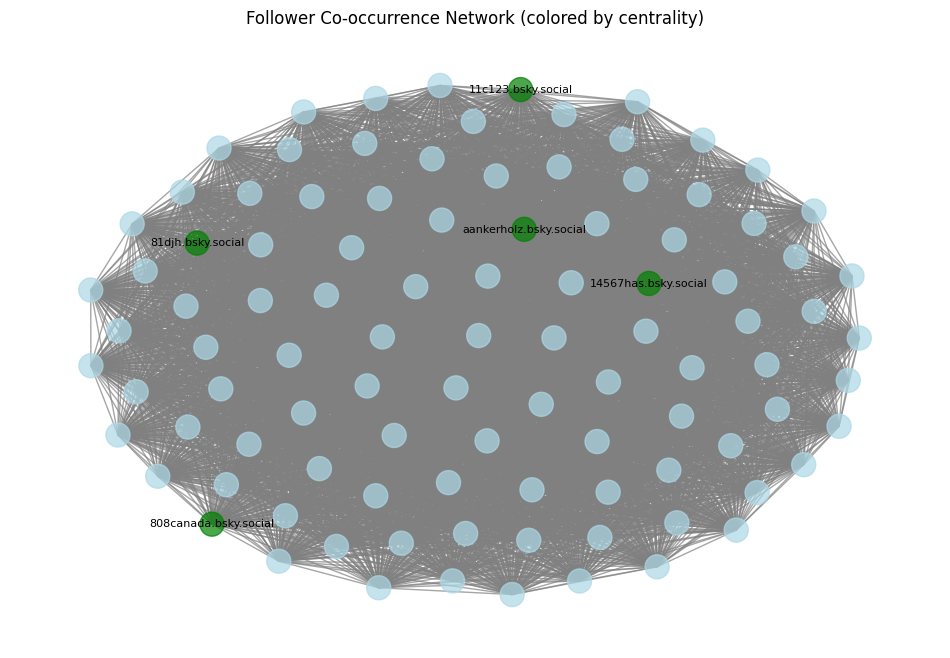

In [69]:
# TODO: Create network visualization
# - Use spring layout
# - Color nodes: green (high degree), red (high betweenness), blue (others)
# - Size nodes based on degree
# - Label top nodes

import matplotlib.pyplot as plt

# Set up positions
pos = nx.spring_layout(G, seed=42, k=0.5)

# Determine node colors
node_colors = []
for node in G.nodes():
    if node in top_degree:
        node_colors.append('green')
    elif node in top_betweenness:
        node_colors.append('red')
    elif node in top_closeness:
        node_colors.append('orange')
    else:
        node_colors.append('lightblue')

# Node sizes proportional to degree
node_sizes = [300 * deg_cent[node] for node in G.nodes()]   # adjust scale

plt.figure(figsize=(12, 8))
nx.draw_networkx(G, pos, node_color=node_colors, node_size=node_sizes,
                 with_labels=False, edge_color='gray', alpha=0.7)

# Draw labels only for top nodes
labels = {node: node for node in set(top_degree + top_betweenness + top_closeness)}
nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.title("Follower Co‑occurrence Network (colored by centrality)")
plt.axis('off')
plt.show()


## 4. Network Analysis

### 4.1 Basic Network Statistics

In [70]:
# TODO: Calculate and print:
# - Number of nodes
# - Number of edges
# - Network density
# - Average degree

# YOUR CODE HERE
n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()
density = nx.density(G)
avg_degree = sum(dict(G.degree()).values()) / n_nodes

print(f"Nodes: {n_nodes}")
print(f"Edges: {n_edges}")
print(f"Density: {density:.4f}")
print(f"Average degree: {avg_degree:.2f}")

Nodes: 100
Edges: 4950
Density: 1.0000
Average degree: 99.00


### 4.2 Degree Distribution

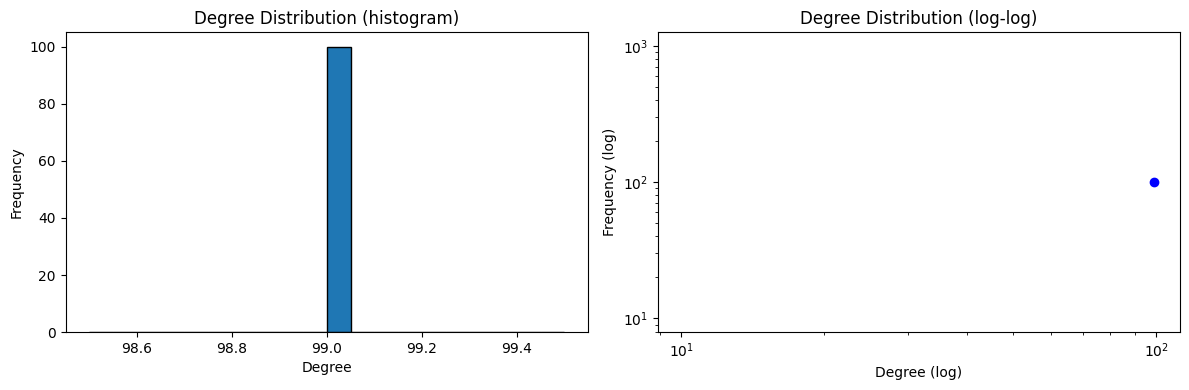

Min degree: 99
Max degree: 99
Median degree: 99.0


In [71]:
# TODO: Analyze degree distribution
# Create 2 plots: histogram and log-log plot
# Print min, max, and median degree

# YOUR CODE HERE
degrees = [d for n, d in G.degree()]

# Histogram
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(degrees, bins=20, edgecolor='black')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution (histogram)')

# Log-log plot
plt.subplot(1,2,2)
from collections import Counter
deg_counts = Counter(degrees)
deg_vals = list(deg_counts.keys())
freqs = list(deg_counts.values())
plt.loglog(deg_vals, freqs, 'bo')
plt.xlabel('Degree (log)')
plt.ylabel('Frequency (log)')
plt.title('Degree Distribution (log‑log)')
plt.tight_layout()
plt.show()

print(f"Min degree: {min(degrees)}")
print(f"Max degree: {max(degrees)}")
print(f"Median degree: {np.median(degrees)}")

### 4.3 Connectivity and Components

In [72]:
# TODO: Analyze connectivity
# Check if connected, count components
# If connected, calculate diameter and average path length

# YOUR CODE HERE
if nx.is_connected(G):
    diameter = nx.diameter(G)
    avg_path = nx.average_shortest_path_length(G)
    print(f"Diameter: {diameter}")
    print(f"Average shortest path length: {avg_path:.3f}")
else:
    components = list(nx.connected_components(G))
    print(f"Number of components: {len(components)}")
    # Diameter for largest component
    G_largest = G.subgraph(max(components, key=len))
    print(f"Largest component size: {G_largest.number_of_nodes()}")
    # Optionally compute diameter for largest
    if nx.is_connected(G_largest):
        print(f"Diameter of largest component: {nx.diameter(G_largest)}")

Diameter: 1
Average shortest path length: 1.000


### 4.4 Clustering

In [73]:
# TODO: Calculate average clustering coefficient
# Print interpretation of the value

# YOUR CODE HERE
avg_clustering = nx.average_clustering(G)
print(f"Average clustering coefficient: {avg_clustering:.4f}")
# Interpretation: high (>0.5) means strong community structure; low (<0.1) means random connections.

Average clustering coefficient: 1.0000


### 4.5 Key Influencers Analysis

Top 10 by degree centrality:
                             degree
11c123.bsky.social              1.0
14567has.bsky.social            1.0
808canada.bsky.social           1.0
81djh.bsky.social               1.0
aankerholz.bsky.social          1.0
ageneralanxiety.bsky.social     1.0
amckeag.bsky.social             1.0
andreapluchino.bsky.social      1.0
anon12-91.bsky.social           1.0
arppodcast.bsky.social          1.0


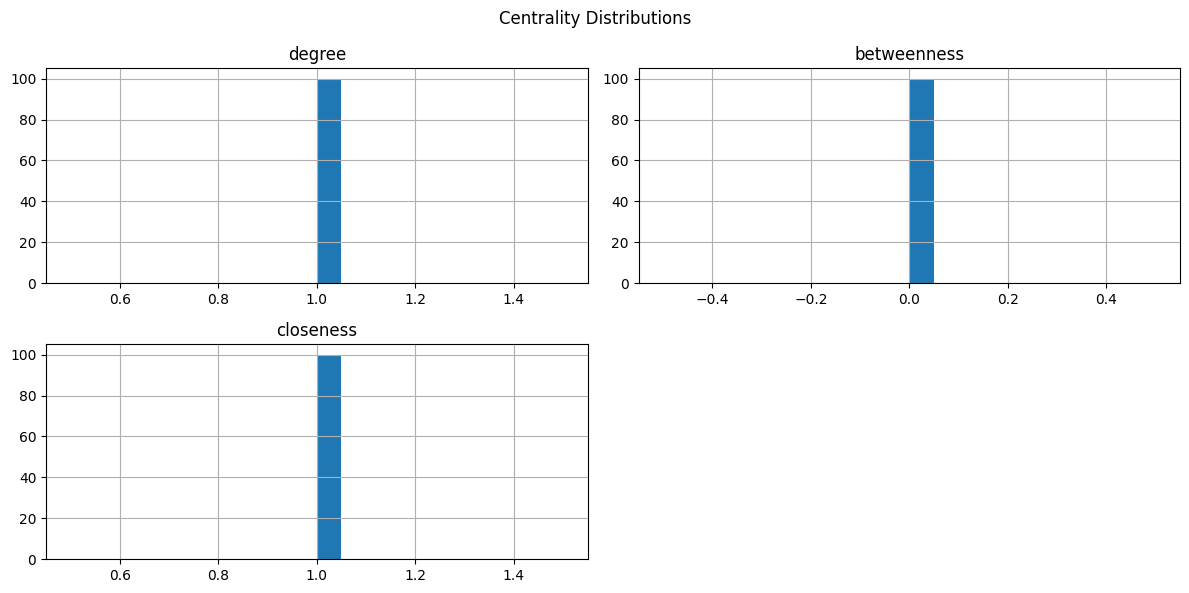

In [74]:
# TODO: Create DataFrame with all three centrality measures
# Print top 10 influencers by degree centrality
# Create 3 histograms showing centrality distributions

# YOUR CODE HERE
# Build a DataFrame
df_centrality = pd.DataFrame({
    'degree': deg_cent,
    'betweenness': bet_cent,
    'closeness': clo_cent
}).fillna(0)   # betweenness might be zero for many nodes

print("Top 10 by degree centrality:")
print(df_centrality.nlargest(10, 'degree')[['degree']])

# Histograms of each metric
df_centrality.hist(bins=20, figsize=(12,6))
plt.suptitle('Centrality Distributions')
plt.tight_layout()
plt.show()

### 4.6 Compare Top Nodes Across Metrics

In [75]:
# TODO: Compare top 10 nodes by each metric
# Create DataFrame showing top nodes for each centrality measure

# YOUR CODE HERE
# Get top 10 nodes for each metric (by index)
top_degree_nodes = df_centrality.nlargest(10, 'degree').index.tolist()
top_betweenness_nodes = df_centrality.nlargest(10, 'betweenness').index.tolist()
top_closeness_nodes = df_centrality.nlargest(10, 'closeness').index.tolist()

# Create a comparison table
comparison = pd.DataFrame({
    'Top Degree': pd.Series(top_degree_nodes),
    'Top Betweenness': pd.Series(top_betweenness_nodes),
    'Top Closeness': pd.Series(top_closeness_nodes)
})
print(comparison)

                    Top Degree              Top Betweenness  \
0           11c123.bsky.social           11c123.bsky.social   
1         14567has.bsky.social         14567has.bsky.social   
2        808canada.bsky.social        808canada.bsky.social   
3            81djh.bsky.social            81djh.bsky.social   
4       aankerholz.bsky.social       aankerholz.bsky.social   
5  ageneralanxiety.bsky.social  ageneralanxiety.bsky.social   
6          amckeag.bsky.social          amckeag.bsky.social   
7   andreapluchino.bsky.social   andreapluchino.bsky.social   
8        anon12-91.bsky.social        anon12-91.bsky.social   
9       arppodcast.bsky.social       arppodcast.bsky.social   

                 Top Closeness  
0           11c123.bsky.social  
1         14567has.bsky.social  
2        808canada.bsky.social  
3            81djh.bsky.social  
4       aankerholz.bsky.social  
5  ageneralanxiety.bsky.social  
6          amckeag.bsky.social  
7   andreapluchino.bsky.social  
8        

## Summary and Insights

### Key Findings

This notebook analyzed a Bluesky follower network with the following results:

1. **Network Size**: The network contains followers from 3 seed accounts
2. **Density**: Shows how interconnected the network is
3. **Key Influencers**: Identified by degree, betweenness, and closeness centrality
4. **Clustering**: Measures community structure and local connectivity

### Reflection Questions

1. **Network Structure**: Is your network densely or sparsely connected? What does this tell you?
2. **Influential Nodes**: Are the top nodes by degree centrality the same as those with high betweenness?
3. **Practical Implications**: Which nodes would you target to spread information quickly?
4. **Limitations**: What are the limitations of this data collection approach?